# Imports

In [4]:
from tensorflow.keras import utils, layers, models, optimizers, losses
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import metrics

# Variables

In [3]:
img_height = 32
img_width = 32
channels = 3
num_units = 200
z_dimensions = 200
learning_rate = 0.0005
beta = 2000
batch_size = 200

# Import the data

In [5]:
coin_data = utils.image_dataset_from_directory(
    "coins",
    labels=None,
    color_mode="rgb",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 3749 files.


# Preprocess the data

In [7]:
train = coin_data.map(lambda image: tf.cast(image, "float32") / 255.0)

In [8]:
def sample_images(dataset):
    images = dataset.take(1).get_single_element()
    if isinstance(images, tuple):
        images = batch[0]
    return images.numpy()

train_sample = sample_images(train)

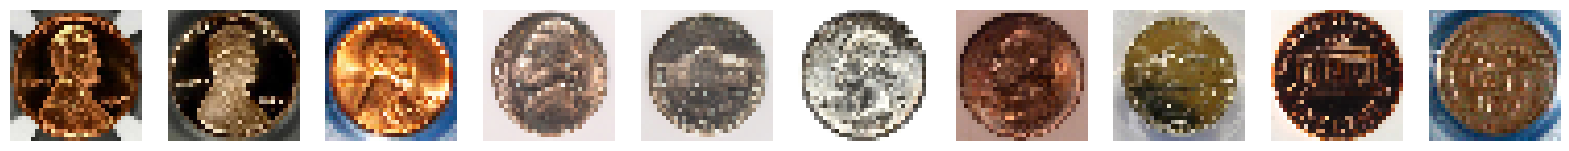

In [9]:
def show_images(images, n=10, size=(20, 3)):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0
    
    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype("float32"), cmap=None)
        plt.axis("off")
    
    plt.show()

show_images(train_sample)

# NormalDistribution layer
The layer sample from the multivariate normal distribution

In [18]:
class NormalDistribution(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        eps = K.random_normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1]))
        return mean + tf.exp(0.5 * log_var) * eps

# Encoder

In [21]:
coin_encoder_input = layers.Input(shape=(img_height, img_width, channels), name="coin_encoder_input")

x = layers.Conv2D(num_units, kernel_size=3, strides=2, padding="same")(coin_encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(num_units, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(num_units, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(num_units, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

shape_prior_to_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
norm_mean = layers.Dense(z_dimensions, name="norm_mean")(x)
norm_log_var = layers.Dense(z_dimensions, name="norm_log_var")(x)
z = NormalDistribution()([norm_mean, norm_log_var])
coin_encoder = models.Model(coin_encoder_input, [norm_mean, norm_log_var, z], name="coin_encoder")
coin_encoder.summary()

Model: "coin_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ coin_encoder_input  │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      5,600 │ coin_encoder_inp… │
│                     │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        800 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 200) │    360,200 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 200) │        800 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 200) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 200) │    360,200 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 200) │        800 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 4, 4, 200) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 2, 2, 200) │    360,200 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 200) │        800 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 2, 2, 200) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 800)       │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_mean (Dense)   │ (None, 200)       │    160,200 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_log_var        │ (None, 200)       │    160,200 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normal_distribution │ (None, 200)       │          0 │ norm_mean[0][0],  │
│ (NormalDistributio… │                   │            │ norm_log_var[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,409,800 (5.38 MB)

 Trainable params: 1,408,200 (5.37 MB)

 Non-trainable params: 1,600 (6.25 KB)

# Decoder

In [23]:
coin_decoder_input = layers.Input(shape=(z_dimensions,), name="coin_decoder_input")
x = layers.Dense(np.prod(shape_prior_to_flattening))(coin_decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_prior_to_flattening)(x)

x = layers.Conv2DTranspose(num_units, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(num_units, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(num_units, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(num_units, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

coin_decoder_output = layers.Conv2DTranspose(channels, kernel_size=3, strides=1, activation="sigmoid", padding="same")(x)
coin_decoder = models.Model(coin_decoder_input, coin_decoder_output)
coin_decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ coin_decoder_input (InputLayer) │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800)            │         3,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 200)      │       360,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 200)      │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 200)      │       360,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 200)      │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 200)    │       360,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 200)    │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 200)    │       360,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 200)    │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 3)      │         5,403 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,613,403 (6.15 MB)

 Trainable params: 1,610,203 (6.14 MB)

 Non-trainable params: 3,200 (12.50 KB)

# Variational autoencoder

In [27]:
class CoinVae(models.Model):
    def __init__(self, coin_encoder, coin_decoder, **kwargs):
        super(CoinVae, self).__init__(**kwargs)
        self.coin_encoder = coin_encoder
        self.coin_decoder = coin_decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        norm_mean, norm_log_var, z = coin_encoder(inputs)
        reconstruction = coin_decoder(z)
        return norm_mean, norm_log_var, reconstruction

    def train_step(self, data):
        mse = MeanSquaredError()
        with tf.GradientTape() as tape:
            norm_mean, norm_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                beta * mse(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + norm_log_var - tf.square(norm_mean) - tf.exp(norm_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        norm_mean, norm_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            beta * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            
            tf.reduce_sum(
                -0.5 * (1 + norm_log_var - tf.square(norm_mean) - tf.exp(norm_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
     

In [29]:
coin_vae = CoinVae(coin_encoder, coin_decoder)

# Testing of the model

## A batch size 128

### Training of the model

In [32]:
optimiser = optimizers.Adam(learning_rate=learning_rate)
coin_vae.compile(optimizer=optimiser)
coin_vae.fit(train, epochs=100, batch_size=128)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - kl_loss: 0.0379 - loss: 155.1538 - reconstruction_loss: 155.1160
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - kl_loss: 1.7335 - loss: 136.4734 - reconstruction_loss: 134.7399
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - kl_loss: 5.3256 - loss: 108.8432 - reconstruction_loss: 103.5176
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - kl_loss: 6.3797 - loss: 94.9927 - reconstruction_loss: 88.6130
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - kl_loss: 7.4487 - loss: 88.2118 - reconstruction_loss: 80.7631
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - kl_loss: 8.4950 - loss: 87.7112 - reconstruction_loss: 79.2162
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - kl_loss: 8.6981 - loss: 84.0450 - reconstruction_loss: 75.3469
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - kl_loss: 8.7560 - loss: 80.4246 - reconstruction_loss: 71.6686
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - kl_loss: 8.93

### Generating new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


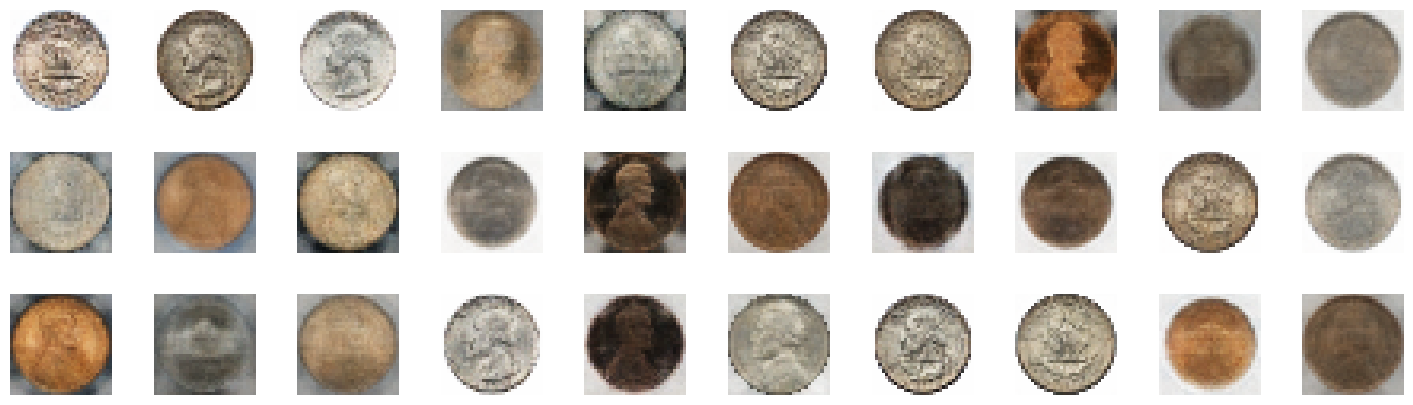

In [41]:
width, height = (10, 3)
sample = np.random.normal(size=(width * height, z_dimensions))
coin_reconstructions = coin_decoder.predict(sample)

figure = plt.figure(figsize=(18, 5))
figure.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(width * height):
    ax = figure.add_subplot(height, width, i + 1)
    ax.axis("off")
    ax.imshow(coin_reconstructions[i, :, :])

plt.show()

# Testing of the model

## A batch size 64

### Training of the model

In [43]:
coin_vae = CoinVae(coin_encoder, coin_decoder)
optimiser = optimizers.Adam(learning_rate=learning_rate)
coin_vae.compile(optimizer=optimiser)
coin_vae.fit(train, epochs=100, batch_size=64)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - kl_loss: 9.5284 - loss: 58.5413 - reconstruction_loss: 49.0130
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - kl_loss: 9.6524 - loss: 51.1719 - reconstruction_loss: 41.5195
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - kl_loss: 9.7002 - loss: 50.4468 - reconstruction_loss: 40.7466
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - kl_loss: 9.6743 - loss: 49.9927 - reconstruction_loss: 40.3184
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - kl_loss: 9.6201 - loss: 50.1365 - reconstruction_loss: 40.5164
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - kl_loss: 9.7789 - loss: 50.2110 - reconstruction_loss: 40.4321
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - kl_loss: 9.6447 - loss: 50.1902 - reconstruction_loss: 40.5455
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - kl_loss: 9.7103 - loss: 50.2879 - reconstruction_loss: 40.5776
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - kl_loss: 9.6862 - l

### Generating new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


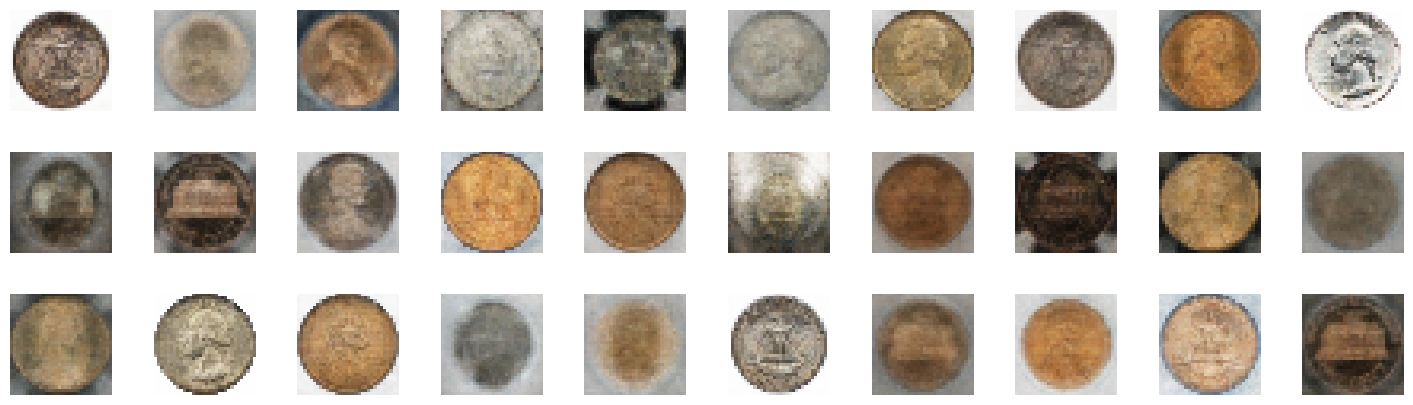

In [44]:
width, height = (10, 3)
sample = np.random.normal(size=(width * height, z_dimensions))
coin_reconstructions = coin_decoder.predict(sample)

figure = plt.figure(figsize=(18, 5))
figure.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(width * height):
    ax = figure.add_subplot(height, width, i + 1)
    ax.axis("off")
    ax.imshow(coin_reconstructions[i, :, :])

plt.show()

# Testing of the model

## A batch size 64

### Training of the model

In [47]:
coin_vae = CoinVae(coin_encoder, coin_decoder)
optimiser = optimizers.Adam(learning_rate=learning_rate)
coin_vae.compile(optimizer=optimiser)
coin_vae.fit(train, epochs=100, batch_size=32)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - kl_loss: 9.8527 - loss: 55.1866 - reconstruction_loss: 45.3339
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - kl_loss: 9.9526 - loss: 48.2093 - reconstruction_loss: 38.2567
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - kl_loss: 9.9856 - loss: 46.7337 - reconstruction_loss: 36.7480
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - kl_loss: 9.9346 - loss: 46.2332 - reconstruction_loss: 36.2986
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - kl_loss: 9.9212 - loss: 46.0987 - reconstruction_loss: 36.1775
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - kl_loss: 10.0156 - loss: 45.9342 - reconstruction_loss: 35.9186
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - kl_loss: 10.0190 - loss: 46.4572 - reconstruction_loss: 36.4382
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - kl_loss: 9.9709 - loss: 46.3992 - reconstruction_loss: 36.4283
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - kl_loss: 10.0536 

### Generating new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


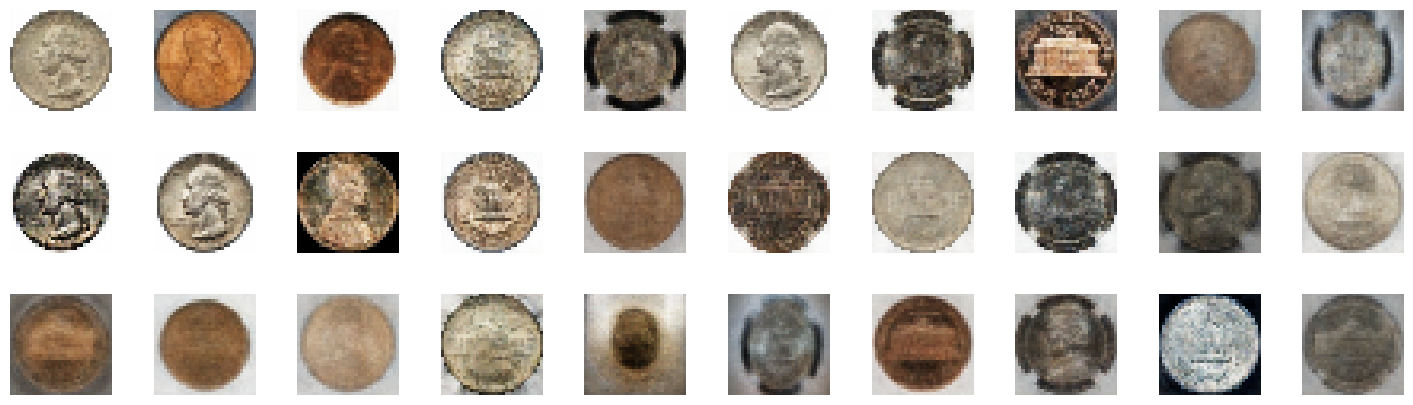

In [48]:
width, height = (10, 3)
sample = np.random.normal(size=(width * height, z_dimensions))
coin_reconstructions = coin_decoder.predict(sample)

figure = plt.figure(figsize=(18, 5))
figure.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(width * height):
    ax = figure.add_subplot(height, width, i + 1)
    ax.axis("off")
    ax.imshow(coin_reconstructions[i, :, :])

plt.show()